## load data and change into h5 files

In [1]:
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import os
import Cooking
import random

In [2]:
RAW_DATA_DIR = 'record/'
COOKED_DATA_DIR = 'data_cooked/'
FIGURE_SIZE = (10,10)
# # The folders to search for data under RAW_DATA_DIR
# # For example, the first folder searched will be RAW_DATA_DIR/normal_1
# DATA_FOLDERS = ['normal_1', 'normal_2', 'normal_3', 'normal_4', 'normal_5', 'normal_6', 'swerve_1', 'swerve_2', 'swerve_3']

In [3]:
data_path = os.path.join(RAW_DATA_DIR, 'airsim_rec.txt')
dataset = pd.read_csv(data_path, sep='\t')
dataset.sample(10)

,VehicleName,TimeStamp,POS_X,POS_Y,POS_Z,Q_W,Q_X,Q_Y,Q_Z,Throttle,Steering,Brake,Gear,Handbrake,RPM,Speed,ImageFile
470,PhysXCar,1714287725902,107.0950,245.8810,26.3799,0.733805,-0.027428,-0.014993,0.678641,0,-1,0,3,0,1765.20,15.42920,img_PhysXCar__0_1714287725901011200.png
738,PhysXCar,1714287740137,239.9310,334.7640,15.4328,0.997211,0.008765,-0.024599,0.069911,0,0,0,2,0,2528.94,17.89370,img_PhysXCar__0_1714287740136726600.png
370,PhysXCar,1714287720597,67.1683,190.9710,19.3934,0.960746,0.015912,-0.010838,0.276761,1,0,0,0,0,4915.33,11.40220,img_PhysXCar__0_1714287720596685900.png
187,PhysXCar,1714287711098,38.3993,95.2418,10.4177,0.908199,0.032479,0.013123,0.417070,0,1,0,2,0,2749.89,18.58780,img_PhysXCar__0_1714287711097349800.png
2680,PhysXCar,1714287841889,723.3620,758.0040,33.9097,0.217296,-0.174847,-0.006292,-0.960298,1,0,0,3,0,4671.22,17.87470,img_PhysXCar__0_1714287841888694300.png
646,PhysXCar,1714287735115,171.9190,337.2330,16.9517,0.996686,-0.063947,0.049841,0.006574,1,0,0,2,0,4687.80,9.06637,img_PhysXCar__0_1714287735113218800.png
2752,PhysXCar,1714287845702,645.6160,729.2430,46.9909,0.229322,-0.048932,-0.038546,-0.971355,0,-1,0,2,0,1771.81,21.13450,img_PhysXCar__0_1714287845701818500.png
760,PhysXCar,1714287741370,259.7040,338.7090,17.0058,0.986526,0.031990,-0.058303,0.149479,0,0,0,1,0,1344.95,15.18530,img_PhysXCar__0_1714287741369116500.png
1098,PhysXCar,1714287759731,449.4160,341.7510,42.6187,0.996502,-0.018764,-0.000941,-0.081426,0,0,0,1,0,1423.63,14.75980,img_PhysXCar__0_1714287759730842000.png
1961,PhysXCar,1714287804477,824.8490,545.4710,43.4914,0.670414,-0.041149,-0.014701,0.740700,1,0,0,3,0,4306.37,15.32030,img_PhysXCar__0_1714287804476773000.png


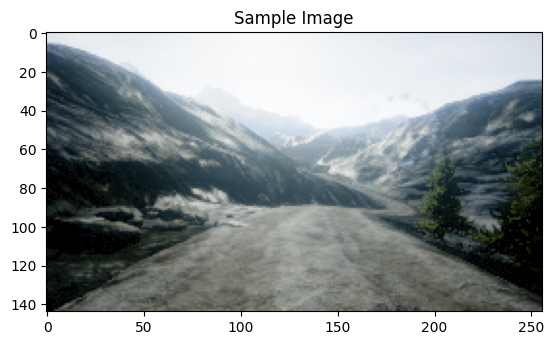

In [4]:
sample_image_path = os.path.join(RAW_DATA_DIR, 'images/img_PhysXCar__0_1714287701007505300.png')
sample_image = Image.open(sample_image_path)
plt.title('Sample Image')
plt.imshow(sample_image)
plt.show()

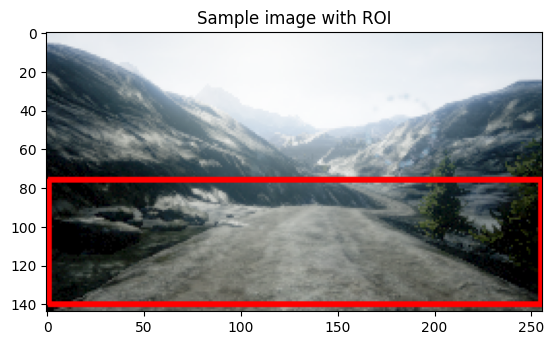

In [5]:
sample_image_roi = sample_image.copy()

fillcolor=(255,0,0)
draw = ImageDraw.Draw(sample_image_roi)
points = [(1,76), (1,140), (255,140), (255,76)]
for i in range(0, len(points), 1):
    draw.line([points[i], points[(i+1)%len(points)]], fill=fillcolor, width=3)
del draw

plt.title('Sample image with ROI')
plt.imshow(sample_image_roi)
plt.show()

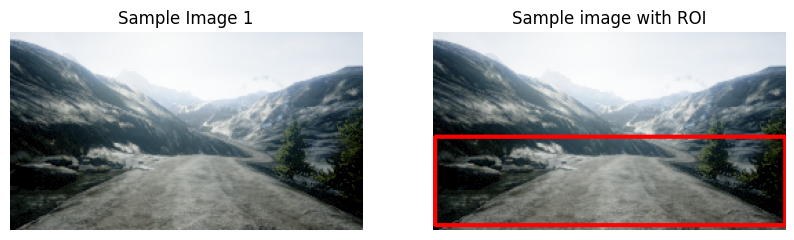

In [7]:
import matplotlib.pyplot as plt
import os
from PIL import Image

# Create subplots with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first image on the left subplot
axes[0].imshow(sample_image)
axes[0].set_title('Sample Image 1')

# Plot the second image on the right subplot
axes[1].imshow(sample_image_roi)
axes[1].set_title('Sample image with ROI')

# Hide the axes ticks
for ax in axes:
    ax.axis('off')

plt.show()


In [8]:
# bins = np.arange(-1, 1.05, 0.05)

# plt.figure(figsize=(5, 5))
# plt.hist(dataset['Throttle'], bins)
# plt.xlabel('Steering Angle')
# plt.ylabel('Normalized Frequency')
# plt.show()

In [9]:
train_eval_test_split = [0.7, 0.2, 0.1]
full_path_raw_folders = [RAW_DATA_DIR]
Cooking.cook(full_path_raw_folders, COOKED_DATA_DIR, train_eval_test_split)

Reading data from record/...
Processing data_cooked/train.h5...
Finished saving data_cooked/train.h5.
Processing data_cooked/eval.h5...
Finished saving data_cooked/eval.h5.
Processing data_cooked/test.h5...
Finished saving data_cooked/test.h5.


## Preprocess data

In [10]:
from keras.preprocessing.image import ImageDataGenerator
from Generator import DriveDataGenerator
from keras.preprocessing import image
import keras.backend as K
import math

MODEL_OUTPUT_DIR = 'model'

2024-05-09 21:06:59.847644: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [11]:
train_dataset = h5py.File(os.path.join(COOKED_DATA_DIR, 'train.h5'), 'r')
eval_dataset = h5py.File(os.path.join(COOKED_DATA_DIR, 'eval.h5'), 'r')
test_dataset = h5py.File(os.path.join(COOKED_DATA_DIR, 'test.h5'), 'r')

num_train_examples = train_dataset['image'].shape[0]
num_eval_examples = eval_dataset['image'].shape[0]
num_test_examples = test_dataset['image'].shape[0]

batch_size=32

In [12]:
train_dataset['label'][0]

array([[-0.33333333],
       [ 1.        ],
       [ 0.        ],
       [ 4.        ]])

In [13]:
data_generator = DriveDataGenerator(rescale=1./255., horizontal_flip=True, brightness_range=(0.6, 1.4))
train_generator = data_generator.flow\
    (train_dataset['image'], train_dataset['previous_state'], train_dataset['label'], batch_size=batch_size, zero_drop_percentage=0.95, roi=[65,140,0,255])
# eval_data_generator = DriveDataGenerator(rescale=1./255., horizontal_flip=False, brightness_range=(1.0, 1.0))
eval_generator = data_generator.flow\
    (eval_dataset['image'], eval_dataset['previous_state'], eval_dataset['label'], batch_size=batch_size, zero_drop_percentage=0, roi=[65,140,0,255])  

Actual Steering Angle = [-1.]


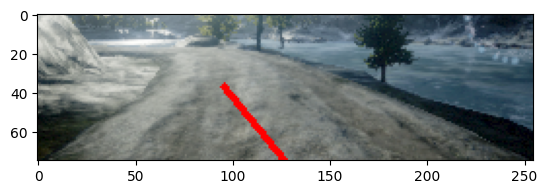

Actual Steering Angle = [0.]


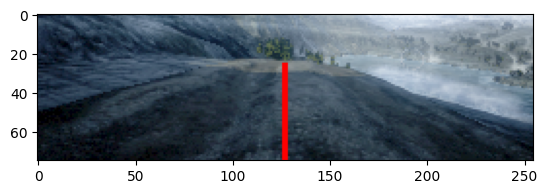

Actual Steering Angle = [0.]


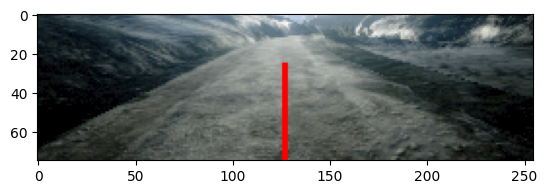

In [18]:
def draw_image_with_label(img, label, prediction=None):
    theta = label * 0.69 #Steering range for the car is +- 40 degrees -> 0.69 radians
    line_length = 50
    line_thickness = 3
    label_line_color = (255, 0, 0)
    prediction_line_color = (0, 0, 255)
    pil_image = image.array_to_img(img, K.image_data_format(), scale=True)
    print('Actual Steering Angle = {0}'.format(label))
    draw_image = pil_image.copy()
    image_draw = ImageDraw.Draw(draw_image)
    first_point = (int(img.shape[1]/2),img.shape[0])
    second_point = (int((img.shape[1]/2) + (line_length * math.sin(theta))), int(img.shape[0] - (line_length * math.cos(theta))))
    image_draw.line([first_point, second_point], fill=label_line_color, width=line_thickness)
    
    if (prediction is not None):
        print('Predicted Steering Angle = {0}'.format(prediction))
        print('L1 Error: {0}'.format(abs(prediction-label)))
        theta = prediction * 0.69
        second_point = (int((img.shape[1]/2) + (line_length * math.sin(theta))), int(img.shape[0] - (line_length * math.cos(theta))))
        image_draw.line([first_point, second_point], fill=prediction_line_color, width=line_thickness)
    
    del image_draw
    plt.imshow(draw_image)
    plt.show()

[sample_batch_train_data, sample_batch_test_data] = next(train_generator)
for i in range(0, 3, 1):
    draw_image_with_label(sample_batch_train_data[0][i], sample_batch_test_data[i][0])

## Train with Kera

In [19]:
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Lambda, Input, concatenate
from keras.layers import BatchNormalization
from tensorflow.keras.layers import ELU
from keras.optimizers import Adam, SGD, Adamax, Nadam
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, CSVLogger, EarlyStopping, ProgbarLogger


In [40]:

image_input_shape = sample_batch_train_data[0].shape[1:]
state_input_shape = sample_batch_train_data[1].shape[1:]
activation = 'relu'

#Create the convolutional stacks
pic_input = Input(shape=image_input_shape)

img_stack = Conv2D(16, (3, 3), name="convolution0", padding='same', activation=activation)(pic_input)
img_stack = MaxPooling2D(pool_size=(2,2))(img_stack)
img_stack = Conv2D(32, (3, 3), activation=activation, padding='same', name='convolution1')(img_stack)
img_stack = MaxPooling2D(pool_size=(2, 2))(img_stack)
img_stack = Conv2D(32, (3, 3), activation=activation, padding='same', name='convolution2')(img_stack)
img_stack = MaxPooling2D(pool_size=(2, 2))(img_stack)
img_stack = Flatten()(img_stack)
img_stack = Dropout(0.2)(img_stack)

#Inject the state input
state_input = Input(shape=state_input_shape)
merged = concatenate([img_stack, state_input])

# Add a few dense layers to finish the model
merged = Dense(64, activation=activation, name='dense0')(merged)
merged = Dropout(0.2)(merged)
merged = Dense(10, activation=activation, name='dense2')(merged)
merged = Dropout(0.2)(merged)
merged = Dense(4, name='output')(merged)

adam = Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model = Model(inputs=[pic_input, state_input], outputs=merged)
model.compile(optimizer=adam, loss='mse')

In [41]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 75, 255, 3)]         0         []                            
                                                                                                  
 convolution0 (Conv2D)       (None, 75, 255, 16)          448       ['input_7[0][0]']             
                                                                                                  
 max_pooling2d_9 (MaxPoolin  (None, 37, 127, 16)          0         ['convolution0[0][0]']        
 g2D)                                                                                             
                                                                                                  
 convolution1 (Conv2D)       (None, 37, 127, 32)          4640      ['max_pooling2d_9[0][0]'

In [42]:
plateau_callback = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.0001, verbose=1)
checkpoint_filepath = os.path.join(MODEL_OUTPUT_DIR, 'models', '{0}_model.{1}-{2}.h5'.format('model', '{epoch:02d}', '{val_loss:.7f}'))
Cooking.checkAndCreateDir(checkpoint_filepath)
checkpoint_callback = ModelCheckpoint(checkpoint_filepath, save_best_only=True, verbose=1)
csv_callback = CSVLogger(os.path.join(MODEL_OUTPUT_DIR, 'training_log.csv'))
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
callbacks=[plateau_callback, csv_callback, checkpoint_callback, early_stopping_callback, ProgbarLogger()]

In [43]:
history = model.fit(train_generator, steps_per_epoch=num_train_examples//batch_size, epochs=100, callbacks=callbacks,\
                   validation_data=eval_generator, validation_steps=num_eval_examples//batch_size, verbose=2)

Epoch 1/100

Epoch 1: val_loss improved from inf to 0.79444, saving model to model/models/model_model.01-0.7944396.h5
63/63 - 13s - loss: 0.9973 - val_loss: 0.7944 - lr: 0.0010 - 13s/epoch - 206ms/sample
Epoch 2/100

Epoch 2: val_loss improved from 0.79444 to 0.74499, saving model to model/models/model_model.02-0.7449932.h5
63/63 - 11s - loss: 0.8667 - val_loss: 0.7450 - lr: 0.0010 - 11s/epoch - 181ms/sample
Epoch 3/100

Epoch 3: val_loss improved from 0.74499 to 0.67085, saving model to model/models/model_model.03-0.6708493.h5
63/63 - 11s - loss: 0.8098 - val_loss: 0.6708 - lr: 0.0010 - 11s/epoch - 182ms/sample
Epoch 4/100

Epoch 4: val_loss improved from 0.67085 to 0.60126, saving model to model/models/model_model.04-0.6012605.h5
63/63 - 11s - loss: 0.7489 - val_loss: 0.6013 - lr: 0.0010 - 11s/epoch - 179ms/sample
Epoch 5/100

Epoch 5: val_loss improved from 0.60126 to 0.57844, saving model to model/models/model_model.05-0.5784429.h5
63/63 - 11s - loss: 0.6698 - val_loss: 0.5784 - lr

1/1 [==============================] - 0s 59ms/step
Actual Steering Angle = [0.33333333]
Predicted Steering Angle = 0.6951345205307007
L1 Error: [0.36180119]


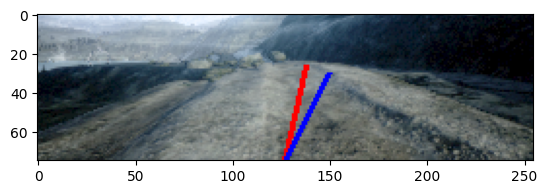

Actual Steering Angle = [0.33333333]
Predicted Steering Angle = 0.6824941039085388
L1 Error: [0.34916077]


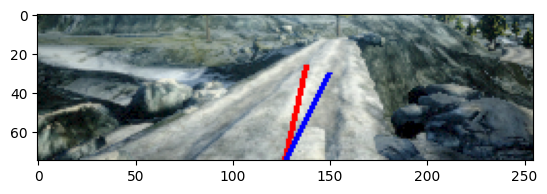

Actual Steering Angle = [1.]
Predicted Steering Angle = 0.9408968687057495
L1 Error: [0.05910313]


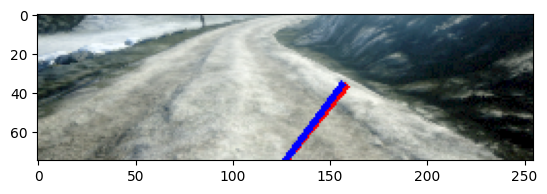

In [46]:
[sample_batch_train_data, sample_batch_test_data] = next(train_generator)
predictions = model.predict([sample_batch_train_data[0], sample_batch_train_data[1]])
for i in range(5, 8, 1):
    draw_image_with_label(sample_batch_train_data[0][i], sample_batch_test_data[i][0], predictions[i][0])

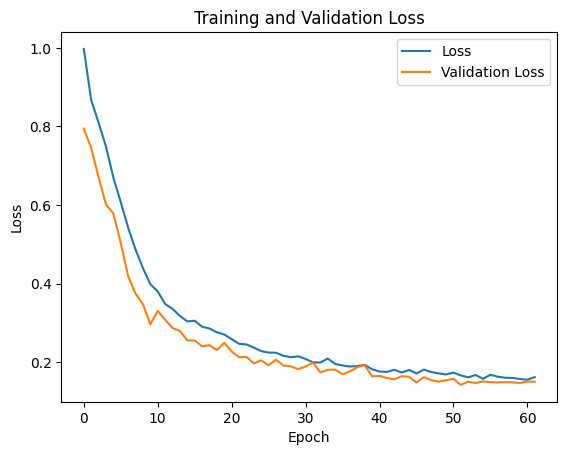

In [47]:
df_loss = pd.read_csv(os.path.join(MODEL_OUTPUT_DIR, 'training_log.csv'))

# Extract the 'loss' and 'val_loss' columns
train_loss = df_loss['loss']
val_loss = df_loss['val_loss']

# Plot the data
plt.plot(train_loss, label='Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## Test performace

In [30]:
# import airsim
# client = airsim.CarClient()
# client.confirmConnection()
# client.enableApiControl(True)
# car_controls = airsim.CarControls()
# print('Connection established!')

# car_controls.steering = 0
# car_controls.throttle = 0
# car_controls.brake = 0
# car_controls.gear = 0

# image_buf = np.zeros((1, 75, 255, 3))
# state_buf = np.zeros((1,4))

# def get_image():
#     image_response = client.simGetImages([airsim.ImageRequest(0, airsim.ImageType.Scene, False, False)])[0]
#     image1d = np.frombuffer(image_response.image_data_uint8, dtype=np.uint8)
#     image_rgba = image1d.reshape(image_response.height, image_response.width, 3)
    
#     return image_rgba[65:140,0:255,0:3].astype(float)

# while (True):
#     car_state = client.getCarState()
    
#     # if (car_state.speed < 5):
#     #     car_controls.throttle = 1.0
#     # else:
#     #     car_controls.throttle = 0.0
    
#     image_buf[0] = get_image()
#     state_buf[0] = np.array([car_controls.steering, car_controls.throttle, car_controls.brake, car_state.speed])
#     model_output = model.predict([image_buf, state_buf])
#     car_controls.steering = float(model_output[0][0])
#     car_controls.throttle = float(model_output[0][1])
#     car_controls.brake = float(model_output[0][2])
#     car_controls.gear = float(model_output[0][3])
#     # car_controls.steering = round(0.03 * float(model_output[0][0]), 2)
#     #0.03完美
#     print('Sending steering = {0}, throttle = {1}'.format(car_controls.steering, car_controls.throttle))
    
#     client.setCarControls(car_controls)

ModuleNotFoundError: No module named 'tornado.platform.auto'